In [1]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import openpyxl
from statistics import * 
from cycler import cycler
from scipy import stats
from gcplot import gc
import importlib

ImportError: DLL load failed: The specified module could not be found.

In [2]:
#User enters data here

file = 'GCData_TE_ML w Conc Data Summary.xlsx' #file name
file = 'GCData-SSM_mutants1-4 w Conc Data.xlsx'
samples = ['ClFatB3','ClFatB3_tr','ClFatB3_tr_M1','ClFatB3_tr_M2','ClFatB3_tr_M3'] #name of samples
samples = ['BTE-QE','H170E','M197F','M197V','Neg','R168A','Rec','WT']
### ^^Do these have to be in order? 
### ^^Yes, they have to be in order of appearance. I'm trying to see if I can get that fixed
numVials = [3, 3, 3, 3, 3, 3, 3, 3] ### USER INPUT number of vials per sample in order of appearance 
chains = ['C8','C10','C12:1','C12','C14:1','C14','C16:1','C16','C18:1','C18'] #chain lengths

#Graph options
title = 'Free fatty acid distribution of ClFatB3 variants' #graph title
ylabel = 'mg/L FAME' #y axis label
graphWidth = 9 #Default 6.0
graphHeight = 4 #Default 4.0
barWidth = 0.6 #Default 0.8
legendLocation = 'upper left' #Default 'best' or Choose: 'upper right/center/left', 'lower right/center/left'
#plt.rcParams["font.family"] = "Times New Roman"



### Python Default
#plt.rcParams["font.family"] = 'DejaVu Sans'

#Should be the same from batch to batch
sheet = 'Corrected Concentration' #sheet with corrected concentration data

# Check to see if lists samples and numVials are the same length
if len(samples) != len(numVials):
    raise Exception('Length of samples and numVials lists must be the same, hoe!') #love it
    
#avgMat = 0

## New

In [35]:
importlib.reload(gc)
df = gc.getCorrectedConcentration(file, sheet)
df_mean, df_err = gc.dataParse(df,chains)

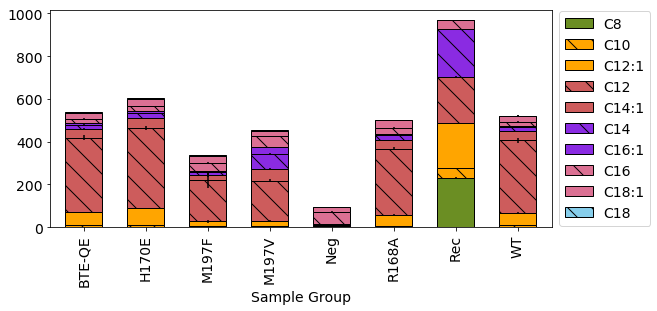

In [37]:
fig, ax = plt.subplots(figsize = (graphWidth, graphHeight))
csfont = {'fontname':'Times New Roman'}
colorwheel = ('olivedrab', 'orange', 'orange', 'indianred','indianred','blueviolet','blueviolet','palevioletred','palevioletred','skyblue','skyblue')
plt.rcParams.update({'font.size': 14})
plt.rcParams['axes.prop_cycle'] = cycler(color=colorwheel)

ax = df_mean.plot.bar(ax = ax, stacked=True, edgecolor = 'k', width = barWidth, yerr = df_err)

bars = ax.patches
patterns = (['']*len(samples) + ['\\']*len(samples))*len(chains)
for bar, pattern in zip(bars, patterns):
    bar.set_hatch(pattern)
    
    
plt.legend(bbox_to_anchor = [1,.5], loc='center left');
plt.show()

## Old

In [3]:
#this function arranges data into an appropriate matrix. correctedConc should be clean with no empty spaces
def dataArrange(correctedConc, numTotSamples):
    numChains = int(len(correctedConc)/numTotSamples)
    rearranged = np.array(correctedConc).reshape((numTotSamples, numChains))
    return rearranged.T, rearranged.T.shape

In [4]:
#Returns average and standard deviation data in the form of matricies
def dataParse(rearranged, samples, numVials):
    
    #rearranged - the rearranged corrected concentration data table with each row corresponding to a chain length
        #and each column corresponding to a sample vial i.e.
        #
        #         H204A-1  H204A-2  H204A-3    WT-1    WT-2    WT-3
        #   C8 [[    #        #        #        #        #        #    ],
        #  C10  [    #        #        #        #        #        #    ],
        #  C12  [    #        #        #        #        #        #    ],
        #  C14  [    #        #        #        #        #        #    ],
        #  C16  [    #        #        #        #        #        #    ]]
        #
    #samples - list of each type of sample i.e. [H204A, WT]
    #numVials - number of vials per sample in order of appearance i.e. [3, 3]
    
    numChains = int(len(rearranged[0])) #number of chain lengths testing for
    avgMat = np.zeros((numChains, len(samples))) #matrix to store average data
    stdevMat = np.zeros((numChains, len(samples))) #matrix to store stdev data

    row_number = range(0,len(chains))
    column_number = range(0,len(samples))

    for r in row_number:
        #print(rearranged[0][r])
        for c in column_number:
            avgMat[r,c] = np.mean(rearranged[0][r][c*3:(c*3)+3]) # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
            stdevMat[r,c] = stats.sem(rearranged[0][r][(c*3):(c*3)+3])
        
    return avgMat,stdevMat

In [5]:
#Creates stacked bar chart of chain length distributions
def createBarChart (file, sheet, samples, numVials, chains, title, ylabel):
    global avgMat
    global rearranged
    
    
    csfont = {'fontname':'Times New Roman'}
    colorwheel = ('olivedrab', 'orange', 'orange', 'indianred','indianred','blueviolet','blueviolet','palevioletred','palevioletred','skyblue','skyblue')
    #get concentration data from excel sheet
    concData = getCorrectedConcentration(file,sheet)
    #arrange data into more managable rows and columns
    rearranged = dataArrange(concData, sum(numVials))
    
    #get mean and standard deviation data
    avgMat, stdevMat = dataParse(rearranged, samples, numVials)
    df_avg = pd.DataFrame(avgMat, columns=samples)
    df_std = pd.DataFrame(stdevMat, columns=samples)
    
    #NEW!! (11/25/20) Calculate totals for percent stacked bar chart
    total = avgMat.sum(axis = 0)
    scaledMat = np.transpose(np.true_divide(avgMat, total)*100)
    df_scaled = pd.DataFrame(scaledMat, index=samples, columns=chains)

    #plot data
    %matplotlib inline
    N = len(samples)
    ind = np.arange(N)
    firstMean = df_avg.loc[0,:]
    firstStd = df_std.loc[0,:]
    plt.figure(figsize=(graphWidth,graphHeight))
    plt.rcParams.update({'font.size': 14})
    plt.rcParams['axes.prop_cycle'] = cycler(color=colorwheel)
    fistplot = plt.bar(ind, firstMean, width=barWidth, yerr=firstStd, label=chains[0], edgecolor = 'k')
    sumMeans = [0]*len(samples)
    for chain in range(1,len(chains)):
        chainMean = df_avg.loc[chain,:]
        prevChainMean = df_avg.loc[chain-1,:]
        for i in range(len(sumMeans)):
            sumMeans[i] = sumMeans[i] + prevChainMean[i]
        chainStd = df_std.loc[chain,:]
        if chain%2 == True:
            plt.bar(ind, chainMean, width=barWidth, bottom=sumMeans, yerr=chainStd, label=chains[chain], hatch = "\\", edgecolor = 'k')
        else:
            plt.bar(ind, chainMean, width=barWidth, bottom=sumMeans, yerr=chainStd, label=chains[chain], edgecolor = 'k')
    plt.xticks(ind,samples, rotation = 45)
    plt.yticks(np.arange(0,1200,200))
    plt.legend(bbox_to_anchor = [1,.5], loc='center left')
    plt.suptitle(title)
    plt.ylabel(ylabel)
    plt.show
    plt.savefig('Banerjee_Jindra_Fig6', bbox_inches = "tight", dpi = 500)
    
    
    #NEW!! (11/25/20) plot scaled bar chart
    scaled = df_scaled.plot(kind = 'bar', 
                            stacked = True, 
                            rot = 45, #xaxis label rotation
                            figsize=(graphWidth, graphHeight), 
                            title = title + " Distribution",
                            width = barWidth)
    
    scaled.legend(bbox_to_anchor = [1,.5], loc='center left')
    scaled.set_ylabel('Product Distribution')  

In [26]:
#returns clean list of corrected concentrations from an excel file
def getCorrectedConcentration (file, sheet):
    wb = openpyxl.load_workbook(file)
    df = pd.read_excel(file, sheetname=sheet)
    correctedConc = []
    title = "-".join(df[0][0].split('-')[:-1])
    for i in df.index:
        conc = df['Corrected Concentration'][i]
        sample = df[0][i] if isinstance(df[0][i], float) or isinstance(df[0][i], int) else "-".join(df[0][i].split('-')[:-1])
        if isinstance(sample, str) and sample != '':
            title = sample
        if title in samples and isinstance(conc, float) and not math.isnan(conc): #math.isnan returns True if conc is nan
            correctedConc.append(conc)
    print(len(correctedConc))
    return correctedConc

240


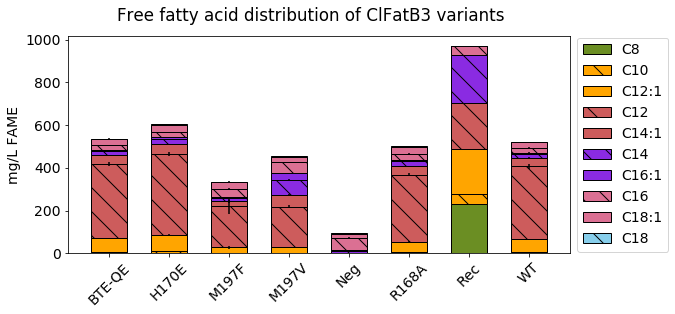

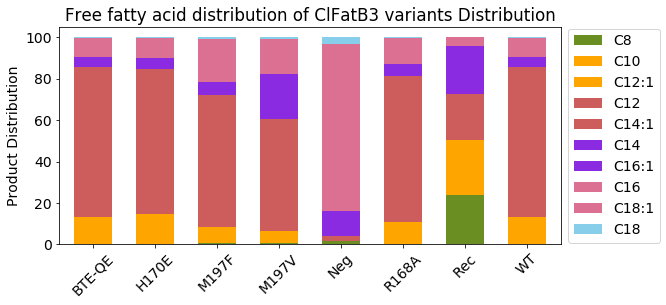

In [27]:
createBarChart(file, sheet, samples, numVials, chains, title, ylabel)

In [41]:

row_number = range(0,len(chains))
column_number = range(0,len(samples))
sample_number = range(0,len(samples*3))
avgPerMat = np.zeros((len(chains), len(samples))) #matrix to store average data
stdErrPerMat = np.zeros((len(chains), len(samples))) #matrix to store std error data
rearranged_per = np.zeros((len(chains), len(samples)*3))
combinedMat = np.zeros((len(chains), len(samples)), dtype = 'object')

TotTit = np.zeros((len(samples*3)))
avgTotTit = np.zeros((len(samples)))
stdErrTotTit = np.zeros((len(samples)))
combinedTotTit = np.zeros((len(samples)), dtype = 'object')


for s in sample_number:
    rearranged_sum = rearranged[0][:,s].sum()
    TotTit[s] = rearranged_sum
    rearranged_per_slice = rearranged[0][:,s]/rearranged_sum
    rearranged_per[:,s] = rearranged_per_slice # creates matrix like rearranged but every entry is a percent of total titer, each column is one sample, each row is a different chain length
    
for r in row_number:
    for c in column_number:
        avgPerMat[r,c] = round(np.mean(rearranged_per[r][(c*3):(c*3)+3]),4)*100 # rearranged is an array which is set up such that each row contains the concentration for a given chain length for all samples
        stdErrPerMat[r,c] = round((stats.sem(rearranged_per[r][(c*3):(c*3)+3])),4)*100
        #stdErrPerMat[r,c] = (np.std(rearranged_per[r][(c*3):(c*3)+3]))/np.sqrt(3)
        avgTotTit[c] = round(np.mean(TotTit[c*3:(c*3)+3]),4)
        stdErrTotTit[c] = round(stats.sem(TotTit[c*3:(c*3)+3]),4)

for r in row_number:
    for c in column_number:
        #avgPerMat[r,c] = str(avgPerMat[r,c])
        #stdErrPerMat[r,c] = str(stdErrPerMat[r,c])
        waxednvaxed = (str(avgPerMat[r,c])[:5], str(stdErrPerMat[r,c])[:5])
        hotgrlsummer = ((str(avgTotTit[c]))[:5], str(stdErrTotTit[c])[:4])
        #print(waxednvaxed)
        combinedMat_entry = "±".join(waxednvaxed)
        combinedMat[r,c] = combinedMat_entry
        
        combinedTotTit_entry = '±'.join(hotgrlsummer)
        combinedTotTit[c] = combinedTotTit_entry

combinedMat = combinedMat.T
#combinedTotTit = combinedTotTit.T

combinedMat = np.column_stack((combinedMat,combinedTotTit))


In [42]:
rearranged[0][:,0]

array([   1.72529615,    6.92860621,   62.57831108,  368.53015496,
         44.74603862,   21.29241481,    6.16974786,   25.68683167,
         32.72884582,    1.98813936])

In [43]:
stdErrTotTit

array([ 18.3971,  12.1701,  51.8766,  18.5868,   5.0187,   5.223 ,
         6.0721,  20.3692])

In [44]:
pd.DataFrame(combinedMat)

,0,1,2,3,4,5,6,7,8,9,10
0,0.31±0.01,1.27±0.04,11.51±0.4,64.82±0.26,7.85±0.03,3.54±0.11,1.0±0.05,4.18±0.2,5.18±0.33,0.33±0.01,537.4±18.3
1,0.3±0.01,1.52±0.02,12.67±0.11,62.33±0.3,8.06±0.05,3.88±0.05,1.27±0.03,4.14±0.05,5.54±0.11,0.3±0.0,603.5±12.1
2,0.45±0.05,0.66±0.03,6.89±0.77,56.89±2.2,6.18±1.24,5.1±0.15,1.24±0.1,12.12±2.61,9.58±1.15,0.89±0.18,336.2±51.8
3,0.5±0.01,0.33±0.0,5.83±0.06,41.4±0.05,12.4±0.17,15.19±0.03,6.85±0.03,11.29±0.09,5.58±0.12,0.64±0.01,454.1±18.5
4,1.58±0.01,0.0±0.0,0.0±0.0,2.21±0.11,0.15±0.15,5.49±0.43,6.47±0.96,61.08±2.21,19.99±1.94,3.02±0.09,95.00±5.01
5,0.31±0.01,0.98±0.16,9.69±0.92,62.36±1.09,8.22±0.18,4.37±0.41,1.1±0.01,5.82±0.82,6.72±0.69,0.44±0.05,501.6±5.22
6,23.95±0.13,4.59±0.04,21.82±0.08,22.23±0.09,0.0±0.0,23.0±0.14,0.0±0.0,4.33±0.01,0.0±0.0,0.07±0.0,969.0±6.07
7,0.3±0.01,1.29±0.04,11.56±0.42,64.77±0.35,7.87±0.02,3.57±0.13,0.98±0.06,4.22±0.25,5.11±0.37,0.35±0.03,522.4±20.3


In [50]:
filename = 'GCData_TE_ML.xlsx'
wb = openpyxl.load_workbook(filename)
sheet1 = ''
sheet1 = wb.create_sheet('final_output')

for line in combinedMat:
    line = line.tolist()
    sheet1.append(line)
      
wb.save(filename)

In [15]:
avgMat

NameError: name 'avgMat' is not defined

In [18]:
num_Exp = len(samples)
library_summary = np.zeros((num_Exp,2)) 
print(library_summary)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]


In [19]:
# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    titer = 0
    for analyte in avgMat:
        titer = titer + analyte[sample]
        
    library_summary[sample, 1] = titer
    

# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    C14_titer = 0
    C12_titer = 0
    titer = 0
    counter = 1
    for analyte in avgMat[2:6]: #looking at C12 and C14 fractions only
        if counter < 3:
            C12_titer = C12_titer + analyte[sample]
        
        elif counter >= 3:
            C14_titer = C14_titer + analyte[sample]
            
        counter = counter+1
    
    ratio = C12_titer/C14_titer
    library_summary[sample, 0] = ratio

In [20]:
library_summary

array([[  7.51056897e+00,   4.26143881e+02],
       [  1.98997024e+00,   7.86335201e+01],
       [  6.57891171e+00,   6.53396050e+02],
       [  8.89866550e+00,   5.56050297e+02],
       [  2.94674350e+00,   1.21940844e+02],
       [  4.19909725e-01,   1.06243614e+02],
       [  1.72996001e+00,   9.67192586e+02],
       [  5.32917048e+00,   6.84548957e+02]])

In [21]:
a = np.round(library_summary,2)
np.trunc(a*10**1)/(10**1)

array([[  7.50000000e+00,   4.26100000e+02],
       [  1.90000000e+00,   7.86000000e+01],
       [  6.50000000e+00,   6.53400000e+02],
       [  8.90000000e+00,   5.56000000e+02],
       [  2.90000000e+00,   1.21900000e+02],
       [  4.00000000e-01,   1.06200000e+02],
       [  1.70000000e+00,   9.67100000e+02],
       [  5.30000000e+00,   6.84500000e+02]])

In [72]:
#Phase 1: Put distribution data into excel

wb = openpyxl.load_workbook('GCData_mutants-Nov19-21 w Conc Data.xlsx')

sheet_output = wb['Table']

In [73]:
x = ['C12:C14 ratio']
for row in a:
    x.append(row[0])

In [74]:
sheet_output.append(x)

In [75]:
y = ['titer']
for row in a:
    y.append(row[1])

In [76]:
sheet_output.append(y)

In [22]:
# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    titer = 0
    for analyte in avgMat:
        titer = titer + analyte[sample]
        
    library_summary[sample, 1] = titer
    

# Populate library_summary array with C12 fraction and total titer

for sample in range(0,num_Exp):
    C12_titer = 0
    titer = 0
    counter = 1
    for analyte in avgMat[2:6]:
        if counter < 3:
            C12_titer = C12_titer + analyte[sample]
            
        titer = titer + analyte[sample]
        counter = counter+1
    
    C12_fraction = C12_titer/titer
    library_summary[sample, 0] = C12_fraction

In [23]:
a = np.round(library_summary,2)
np.trunc(a*10**1)/(10**1)

array([[  8.00000000e-01,   4.26100000e+02],
       [  6.00000000e-01,   7.86000000e+01],
       [  8.00000000e-01,   6.53400000e+02],
       [  9.00000000e-01,   5.56000000e+02],
       [  7.00000000e-01,   1.21900000e+02],
       [  3.00000000e-01,   1.06200000e+02],
       [  6.00000000e-01,   9.67100000e+02],
       [  8.00000000e-01,   6.84500000e+02]])

In [79]:
z = ['C12 fraction']
for row in a:
    z.append(row[0])

In [81]:
sheet_output.append(z)

In [82]:
wb.save('GCData_mutants-Nov19-21 w Conc Data.xlsx')

In [83]:
sheet_output.append(samples)

In [84]:
wb.save('GCData_mutants-Nov19-21 w Conc Data.xlsx')